Running simulation for loss probability: 0.1%...
  -> Throughput (MSS/s): 895.900
Running simulation for loss probability: 1.0%...
  -> Throughput (MSS/s): 277.050
Running simulation for loss probability: 2.0%...
  -> Throughput (MSS/s): 175.050


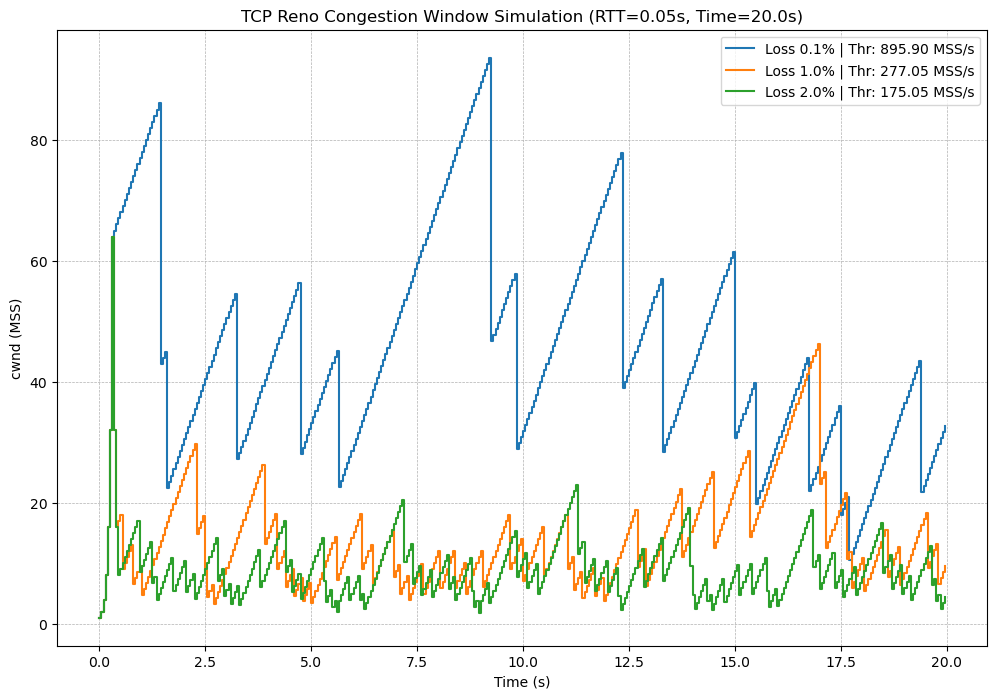


--- Summary ---
Loss 0.1%: Average Throughput = 895.90 MSS/s
Loss 1.0%: Average Throughput = 277.05 MSS/s
Loss 2.0%: Average Throughput = 175.05 MSS/s


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Simulation Parameters ---
RTT = 0.05             # seconds (50 ms)
SIM_TIME = 20.0        # seconds
MSS = 1.0              # normalized MSS (units)
ALGORITHM = "reno"     # "reno"
INITIAL_CWND = 1.0     # in MSS
SSTHRESH_INIT = 64.0   # in MSS

# Define the three loss scenarios to test
LOSS_PROBABILITIES = [0.001, 0.01, 0.02] # 0.1%, 1%, 2%

# --- Simulation Function ---

def run_tcp_simulation(loss_prob, sim_time, RTT, initial_cwnd, ssthresh_init, algorithm):
    """
    Runs the TCP congestion control simulation for a given loss probability.
    Returns: time trace, cwnd trace, and final throughput.
    """
    t = 0.0
    cwnd = initial_cwnd
    ssthresh = ssthresh_init
    time_steps = []
    cwnd_trace = []
    bytes_acked = 0.0
    
    # Helper: simulate sending cwnd-sized window; return True if loss detected
    def send_window(cwnd, loss_prob):
        # Model loss per packet with independent Bernoulli trial
        segs = int(max(1, round(cwnd / MSS)))
        lost = False
        acks = 0
        for _ in range(segs):
            if random.random() < loss_prob:
                lost = True
            else:
                acks += 1
        return lost, acks

    # Main loop: step in RTT-sized intervals
    while t < sim_time:
        # record
        time_steps.append(t)
        cwnd_trace.append(cwnd)

        # determine phase: slow start or congestion avoidance
        in_slow_start = (cwnd < ssthresh)

        # send window, get ack/loss
        lost, acks = send_window(cwnd, loss_prob)

        # update bytes acked
        bytes_acked += acks * MSS

        # Simple Reno behavior
        if lost:
            # Multiplicative Decrease (MD)
            ssthresh = max(cwnd / 2.0, 2.0)
            cwnd = max(cwnd / 2.0, 1.0) # cwnd halving
        else:
            # no loss -> increase cwnd
            if in_slow_start:
                # Slow Start (SS): exponential growth
                cwnd = cwnd * 2.0
            else:
                # Congestion Avoidance (CA): additive increase
                cwnd = cwnd + 1.0
                
        # Cap cwnd (optional, prevents runaway in simple sim)
        cwnd = min(cwnd, 1000.0)

        # advance time by one RTT
        t += RTT

    # Calculate throughput
    throughput = bytes_acked / sim_time
    
    return time_steps, cwnd_trace, throughput

# --- Execution and Plotting ---

plt.figure(figsize=(12, 8))
results = {}

for p in LOSS_PROBABILITIES:
    print(f"Running simulation for loss probability: {p * 100:.1f}%...")
    
    # Run the simulation
    times, cwnds, throughput = run_tcp_simulation(
        p, SIM_TIME, RTT, INITIAL_CWND, SSTHRESH_INIT, ALGORITHM
    )
    
    results[p] = throughput
    
    # Plot the result for this case
    label = f"Loss {p * 100:.1f}% | Thr: {throughput:.2f} MSS/s"
    plt.step(times, cwnds, where='post', label=label)
    
    print(f"  -> Throughput (MSS/s): {throughput:.3f}")


# Finalize Plot
plt.xlabel("Time (s)")
plt.ylabel("cwnd (MSS)")
plt.title(f"TCP Reno Congestion Window Simulation (RTT={RTT}s, Time={SIM_TIME}s)")
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

print("\n--- Summary ---")
for p, thr in results.items():
    print(f"Loss {p * 100:.1f}%: Average Throughput = {thr:.2f} MSS/s")